<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## Open Machine Learning Course

<center>Author: Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU [Dmitriy Sergeyev](https://github.com/DmitrySerg). Translated by: @borowis. <br>Licensed under [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Can be used for any purposes (edited, fixed, used as a base) but commercial, mentioning the author is mandatory.

# <center>Topic 9. Part 1. Time series analysis in Python</center>

Hi there!

We continue our open machine learning course with a new article on time series.

Let's take a look at how to work with time series in Python: what methods and models we can use for prediction, what double and triple exponential smoothing is, what to do if stationarity is not your favorite thing, how to build SARIMA and stay alive, how to make predictions using xgboost... In addition, all of this will be applied to (harsh) real world examples.

[](http://)# Outline:
1. Introduction
   - Basic definitions
   - Quality metrics
2. Move, smoothe, evaluate
   - Rolling window estimations
   - Exponential smoothing, Holt-Winters model
   - Time-series cross validation, parameters selection
3. Econometric approach
   - Stationarity, unit root
   - Getting rid of non-stationarity
   - SARIMA intuition and model building
4. Linear (and not quite) models on time series
   - Feature extraction
   - Linear models, feature importance
   - Regularization, feature selection
   - XGBoost

In my day-to-day, I encounter time-series related tasks almost every day. The most frequent questions asked are the following: what will happen with our metrics in the next day/week/month/etc., how many user will install our app, how much time will they spend online, how many actions will users complete, and so on. We can approach these prediction tasks using different methods depending on the required quality of the prediction, length of the forecast period, and, of course, the time within which we have to choose features and tune parameters to achieve desired results.

# Introduction

We begin with a simple [definition](https://en.wikipedia.org/wiki/Time_series) of time series:
> *Time series* is a series of data points indexed (or listed or graphed) in time order.

Therefore, the data is organized by relatively deterministic timestamps, and may, compared to random sample data, contain additional information that we can extract.

Let's import some libraries. First, we will need the [statsmodels](http://statsmodels.sourceforge.net/stable/) library, which has many statistical modeling functions, including time series. For R afficionados who had to move to Python, `statsmodels` will definitely look more familiar since it supports model definitions like 'Wage ~ Age + Education'.

In [2]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
# from tqdm import tqdm_notebook



%matplotlib inline

As an example, let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day:

In [3]:
ads = pd.read_csv('./data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('./data/currency.csv', index_col=['Time'], parse_dates=['Time'])

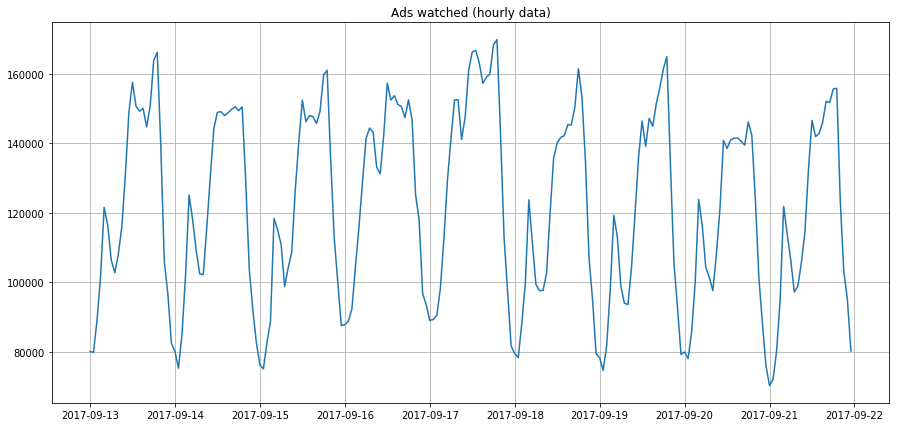

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

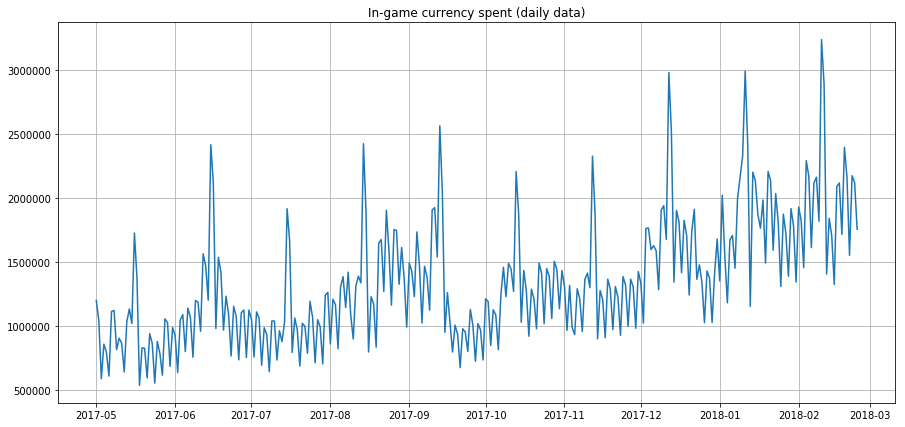

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [12]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Now that we know how to measure the quality of the forecasts, let's see what metrics we can use and how to translate the results for the boss. After that, one small detail remains - building the model.

# Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [13]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [14]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Let's smooth by the previous 4 hours.

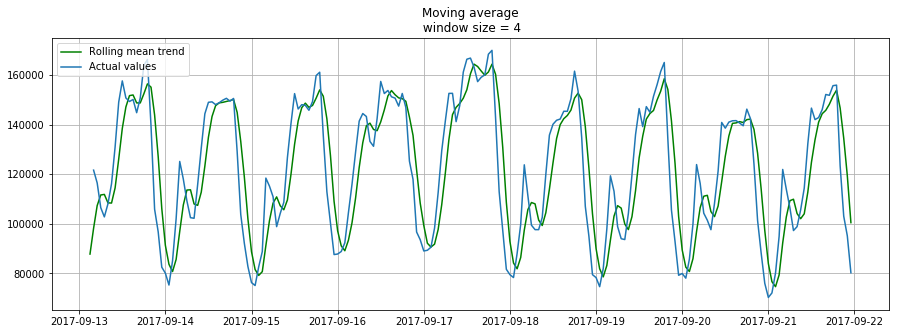

In [15]:
plotMovingAverage(ads, 4) 

Now let's try smoothing by the previous 12 hours.

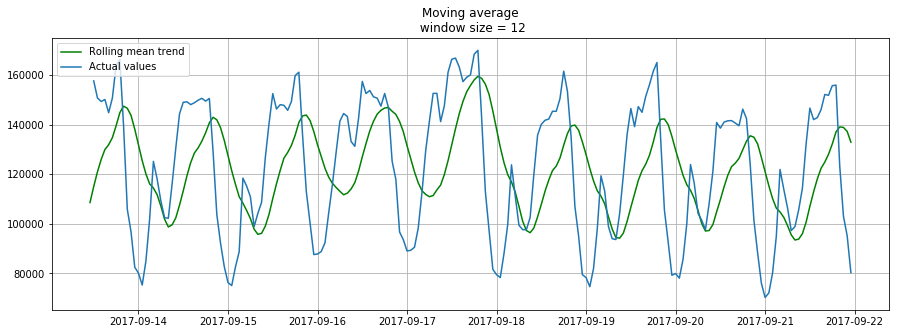

In [16]:
plotMovingAverage(ads, 12) 

Now with the previous 24 hours, we get the daily trend.

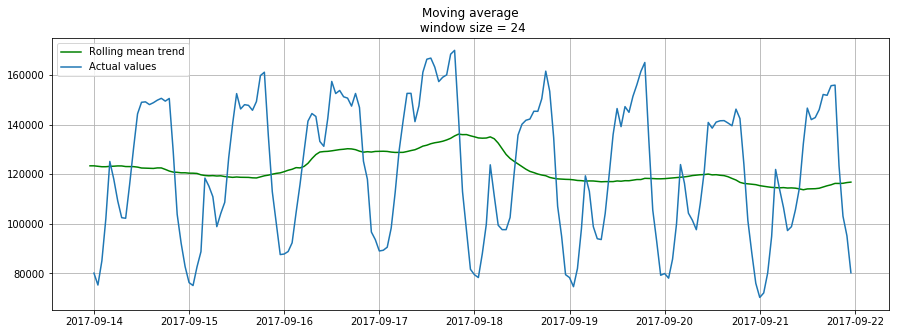

In [17]:
plotMovingAverage(ads, 24)

When we applied daily smoothing on hourly data, we could clearly see the dynamics of ads watched. During the weekends, the values are higher (more time to play on the weekends) while fewer ads are watched on weekdays.

We can also plot confidence intervals for our smoothed values.

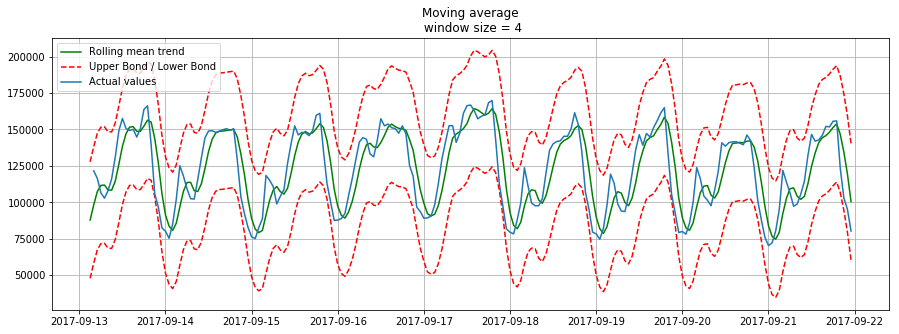

In [18]:
plotMovingAverage(ads, 4, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe `ads_anomaly`.

In [19]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

Let's see if this simple method can catch the anomaly.

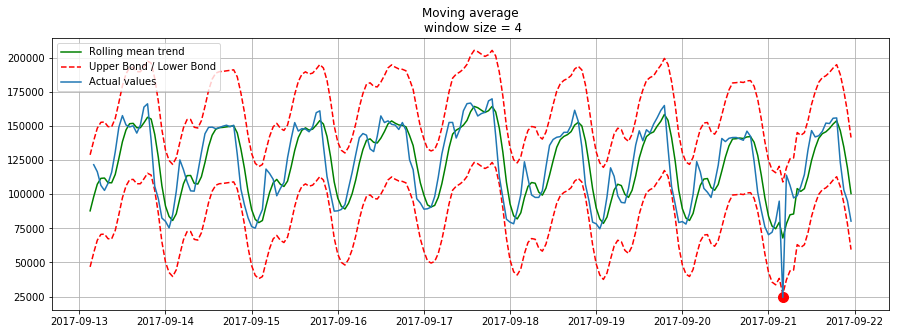

In [20]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

Neat! What about the second series?

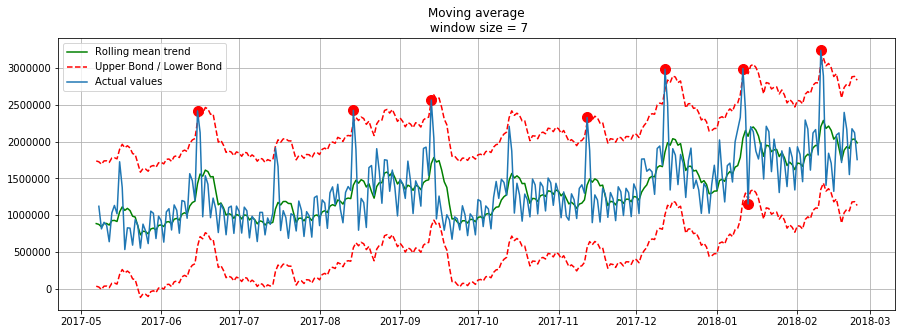

In [21]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

Oh no, this was not as great! Here, we can see the downside of our simple approach -- it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies. If you want to avoid false positives, it is best to consider more complex models. 

**Weighted average** is a simple modification to the moving average. The weights sum up to `1` with larger weights assigned to more recent observations.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [22]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [23]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [ ]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Double exponential smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [ ]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to tune two parameters: $\alpha$ and $\beta$. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

## Triple exponential smoothing a.k.a. Holt-Winters

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series [here](http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time series cross validation

Before we start building a model, let's first discuss how to estimate model parameters automatically.

There is nothing unusual here; as always, we have to choose a loss function suitable for the task that will tell us how closely the model approximates the data. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters, calculate the gradient, adjust the model parameters, and so on, eventually descending to the global minimum.

You may be asking how to do cross-validation for time series because time series have this temporal structure and one cannot randomly mix values in a fold while preserving this structure. With randomization, all time dependencies between observations will be lost. This is why we will have to use a more tricky approach in optimizing the model parameters. I don't know if there's an official name to this, but on [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection), where one can find all answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, the proposed name for this method is "cross-validation on a rolling basis".

The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some $t$, make predictions for the next $t+n$ steps, and calculate an error. Then, we expand our training sample to $t+n$ value, make predictions from $t+n$ until $t+2*n$, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as $n$ will fit between the initial training sample and the last observation.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Now, knowing how to set up cross-validation, we can find the optimal parameters for the Holt-Winters model. Recall that we have daily seasonality in ads, hence the `slen=24` parameter.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [ ]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

Let's add some code to render plots.

In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [ ]:
plotHoltWinters(ads.Ads)

In [ ]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Judging by the plots, our model was able to successfully approximate the initial time series, capturing the daily seasonality, overall downwards trend, and even some anomalies. If you look at the model deviations, you can clearly see that the model reacts quite sharply to changes in the structure of the series but then quickly returns the deviation to the normal values, essentially "forgetting" the past. This feature of the model allows us to quickly build anomaly detection systems, even for noisy series data, without spending too much time and money on preparing the data and training the model.

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

We'll apply the same algorithm for the second series which, as you may recall, has trend and a 30-day seasonality.

In [ ]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

In [ ]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

Looks good! The model caught both upwards trend and seasonal spikes and fits the data quite nicely.

In [ ]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# Econometric approach

### Stationarity

Before we start modeling, we should mention such an important property of time series: [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- The red graph below is not stationary because the mean increases over time.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- We were unlucky with the variance and see the varying spread of values over time

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free.

White noise chart:

In [ ]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

The process generated by the standard normal distribution is stationary and oscillates around 0 with with deviation of 1. Now, based on this process, we will generate a new one where each subsequent value will depend on the previous one: $x_t = \rho x_{t-1} + e_t$ 

Here is the code to render the plots.

In [ ]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first plot, you can see the same stationary white noise as before. On the second plot with $\rho$ increased to 0.6, wider cycles appeared, but it still appears stationary overall. The third plot deviates even more from the 0 mean but still oscillates about the mean. Finally, with $\rho=1$, we have a random walk process i.e. a non-stationary time series.

This happens because, after reaching the critical value, the series $x_t = \rho x_{t-1} + e_t$ does not return to its mean value. If we subtract $x_{t-1}$ from both sides, we will get $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, where the expression on the left is referred to as the first difference. If $\rho=1$, then the first difference gives us stationary white noise $e_t$. This is the main idea behind the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) for stationarity of time series (testing the presence of a unit root). If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1. The null hypothesis of the test is that the time series is non-stationary, which was rejected on the first three plots and finally accepted on the last one. We have to say that the first difference is not always enough to get a stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, which checks multiple lags at once.

We can fight non-stationarity using different approaches: various order differences, trend and seasonality removal, smoothing, and transformations like Box-Cox or logarithmic.

## Getting rid of non-stationarity and building SARIMA

Let's build an ARIMA model by walking through all the ~~circles of hell~~ stages of making a series stationary.

Here is the code to render plots.

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
tsplot(ads.Ads, lags=60)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself -- we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

In [ ]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

In [ ]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

## ARIMA-family Crash-Course

We will explain this model by building up letter by letter. $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which **most** other lags become insignificant.
- $MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before. 

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

- $I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. 

Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

- $S(s)$ - this is responsible for seasonality and equals the season period length of the series

With this, we have three parameters: $(P, D, Q)$

- $P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

- $Q$ - similar logic using the ACF plot instead.

- $D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to set the initial parameters, let's have a look at the final plot once again and set the parameters:

In [ ]:
tsplot(ads_diff[24+1:], lags=60)

- $p$ is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 4 as well as seen on the ACF
- $P$ might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- $D$ again equals 1 because we performed seasonal differentiation
- $Q$ is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

Let's test various models and see which one is better.

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
result_table.head()

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

Let's inspect the residuals of the model.

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [ ]:
plotSARIMA(ads, best_model, 50)

In the end, we got very adequate predictions. Our model was wrong by 4.01% on average, which is very, very good. However, the overall costs of preparing data, making the series stationary, and selecting parameters might not be worth this accuracy.

# Linear (and not quite) models on time series

Often, in my job, I have to build models with [*fast, good, cheap*](http://fastgood.cheap) as my only guiding principle. That means that some of these models will never be considered "production ready" as they demand too much time for data preparation (as in SARIMA) or require frequent re-training on new data (again, SARIMA) or are difficult to tune (good example - SARIMA). Therefore, it's very often much easier to select a few features from the existing time series and build a simple linear regression model or, say, a random forest. It is good and cheap.

This approach is not backed by theory and breaks several assumptions (e.g. Gauss-Markov theorem, especially for errors being uncorrelated), but it is very useful in practice and is often used in machine learning competitions.


# Feature exctraction

The model needs features, and all we have is a 1-dimentional time series. What features can we exctract? 
* Lags of time series
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Date and time features:
    - Minute of an hour, hour of a day, day of the week, and so on
    - Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
* Target encoding 
* Forecasts from other models (note that we can lose the speed of prediction this way)

Let's run through some of the methods and see what we can extract from our ads time series data.

## Lags of time series

Shifting the series $n$ steps back, we get a feature column where the current value of time series is aligned with its value at time $t-n$. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [ ]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [ ]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [ ]:
# take a look at the new dataframe 
data.tail(7)

Great, we have generated a dataset here. Why don't we now train a model? 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us predictions that are not that far off from SARIMA in terms of quality. There are many unnecessary features, so we'll do feature selection in a little while. For now, let's continue engineering!

We'll add hour, day of week, and a boolean for `is_weekend`. To do so, we need to transform the current dataframe index into the `datetime` format and extract `hour` and `weekday`.

In [ ]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

We can visualize the resulting features.

In [ ]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The test error goes down a little bit. Judging by the coefficients plot, we can say that `weekday` and `is_weekend` are useful features.

## Target encoding
I'd like to add another variant for encoding categorical variables: encoding by mean value. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Let's look at the averages by hour.

In [ ]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

Finally, let's put all the transformations together in a single function .

In [ ]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We see some **overfitting**! `Hour_average` was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case. 

In [ ]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Regularization and feature selection 

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function. 

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low. 

As a result of this $L2$ regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called $L1$. 

First, let's make sure that we have features to drop and that the data has highly correlated features.

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.

In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; it removed 23-rd lag from the most important features and dropped 5 features completely, which only made the quality of prediction better.

# Boosting 
Why shouldn't we try XGBoost now?
<img src="https://habrastorage.org/files/754/a9a/26e/754a9a26e59648de9fe2487241a27c43.jpg"/>

In [ ]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

In [ ]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

We have a winner! This is the smallest error on the test set among all the models we've tried so far. 

But, this victory is decieving, and it might not be the brightest idea to fit `xgboost` as soon as you get your hands on time series data. Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use XGBoost. For example, you can forecast trend separately with a linear model and then add predictions from `xgboost` to get a final forecast.

# Conclusion

We discussed different time series analysis and prediction methods. Unfortunately, or maybe luckily, there is no one way to solve these kind of problems. Methods developed in the 1960s (and some even in the beginning of the 21st century) are still popular, along with LSTMs and RNNs (not covered in this article). This is partially related to the fact that the prediction task, like any other data-related task, requires creativity in so many aspects and definitely requires research. In spite of the large number of formal quality metrics and approaches to parameters estimation, it is often necessary to try something different for each time series. Last but not least, the balance between quality and cost is important. As a good example, the SARIMA model can produce spectacular results after tuning but can require many hours of ~~tambourine dancing~~ time series manipulation while a simple linear regression model can be built in 10 minutes and can achieve more or less comparable results.

# Useful resources

- [Online textbook](https://people.duke.edu/~rnau/411home.htm) for the advanced statistical forecasting course at Duke University - covers various smoothing techniques in detail along with linear and ARIMA models
- [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276) - one of a few cases where using random forest for time series forecasting is actively defended
- [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) - applying the ARIMA models family to the task of modeling financial indicators (by Brian Christopher)